In [11]:
import numpy as np
import matplotlib.pyplot as plt

from tqdm.notebook import tqdm

In [12]:
import camb

In [13]:
class LogUniformPrior:

  def __init__(self, limits):

    self.limits = limits
    self.parameter_names = list(limits.keys())
    self.n_params = len(limits)

  def __call__(self, kwargs):
    for key, value in kwargs.items():
      if kwargs[key] < self.limits[key][0] or kwargs[key] > self.limits[key][1]:
        return -np.inf
    return 0

  def generate(self, n_samples):

    samples = np.random.uniform(0,1, (self.n_params, n_samples))

    for i, (key, value) in enumerate(self.limits.items()):
      samples[i] = samples[i] * (value[1] - value[0]) + value[0]
    return samples

In [14]:
def model(params, z_star):

  camb_params = camb.CAMBparams()
  camb_params.set_cosmology(**params)
  camb_result = camb.get_background(camb_params)
  rs_star = camb_result.sound_horizon(z_star)
  Dm_star = camb_result.angular_diameter_distance(z_star) * (1+z_star)

  return rs_star/Dm_star, camb_params.ombh2, camb_params.omch2+camb_params.ombh2

In [15]:
class LogLikelihood:

  def __init__(self):

    self.data = [0.01041, 0.02223, 0.14208]

    self.cov = 1.e-9 * np.array( [ [ 0.006621, 0.12444, -1.1929], [0.12444, 21.344, -94.001], [-1.1929, -94.001, 1488.4]])

    self.inv_cov = np.linalg.inv(self.cov)

    self.z_star = 1089

  def __call__(self, params):

      mu_pred = np.array(model(params, self.z_star))

      diff = self.data-mu_pred

      chi2 = diff @ self.inv_cov @ diff

      return -0.5 * chi2


In [16]:
class MetropolisHastings:

  def __init__(self, log_prior, log_likelihood):

    self.log_prior = log_prior
    self.log_likelihood = log_likelihood
    self.parameter_names = self.log_prior.parameter_names
    self.n_params = self.log_prior.n_params

    self.chain = None
    self.acceptance = None
    self.log_post_chain = None

  def x_to_dict(self, x):

    return {self.parameter_names[i]:x[i] for i in range(len(x))}

  def __call__(self, x0, n_steps, proposal):

    chain = []
    acceptance = [True]

    x0_dict = self.x_to_dict(x0)
    chain.append(x0)
    log_post_chain = [self.log_prior(x0_dict) + self.log_likelihood(x0_dict)]

    for i in tqdm(range(n_steps)):
      x_try = proposal(chain[-1])
      x_try_dict = self.x_to_dict(x_try)

      log_post_chain_try = self.log_likelihood(x_try_dict) + self.log_prior(x_try_dict)
      log_ratio = log_post_chain_try - log_post_chain[-1]
      log_u = np.log(np.random.uniform())

      if log_u < log_ratio:
        chain.append(x_try)
        log_post_chain.append(log_post_chain_try)
        acceptance.append(True)
      else:
        chain.append(chain[-1])
        log_post_chain.append(log_post_chain[-1])
        acceptance.append(False)


      self.chain = np.array(chain)
      self.acceptance = np.array(acceptance)
      self.log_post_chain = np.array(log_post_chain)


In [17]:
limits = {}
limits['H0'] = [60, 75]
limits['omch2'] = [0.11, 0.13]

In [18]:
log_prior = LogUniformPrior(limits)

In [19]:
params = {}
params["H0"] = 70
params["omch2"] = 0.12

print("log prior is:", log_prior(params))

log prior is: 0


In [20]:
log_likelihood = LogLikelihood()
log_likelihood(params)

np.float64(-901.6563641433011)

In [21]:
def proposal(x, loc=[0.1, 0.0005]):
  return np.random.normal(x, loc)

In [22]:
mcmc = MetropolisHastings(log_prior, log_likelihood)
mcmc([65, 0.12], 10000, proposal)

  0%|          | 0/10000 [00:00<?, ?it/s]

In [23]:
sum(mcmc.acceptance), len(mcmc.acceptance)

(np.int64(3909), 10001)

Text(0.5, 0, '$t$')

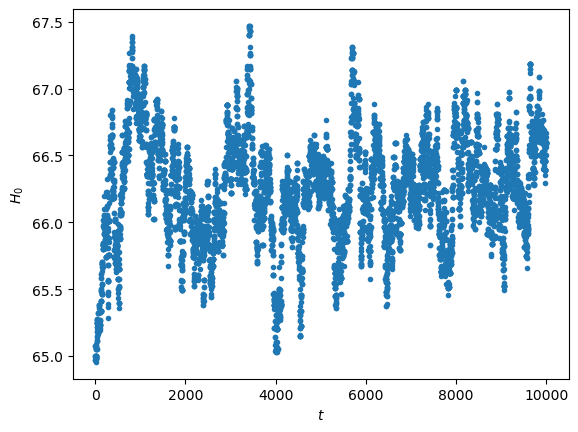

In [24]:
plt.plot(mcmc.chain[:,0],".")
plt.ylabel(r"$H_0$")
plt.xlabel(r"$t$")

Text(0.5, 0, '$t$')

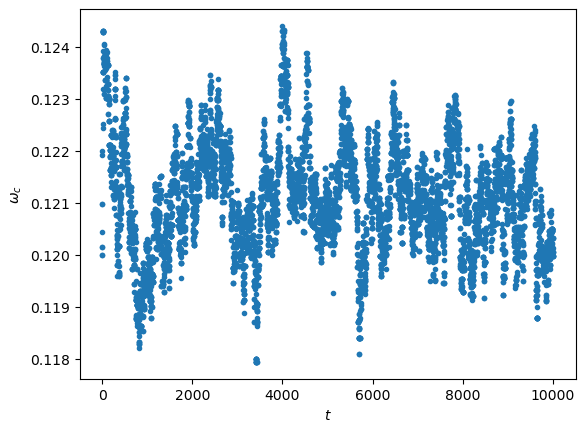

In [25]:
plt.plot(mcmc.chain[:,1],".")
plt.ylabel(r"$\omega_c$")
plt.xlabel(r"$t$")

Text(0, 0.5, '$\\omega_c$')

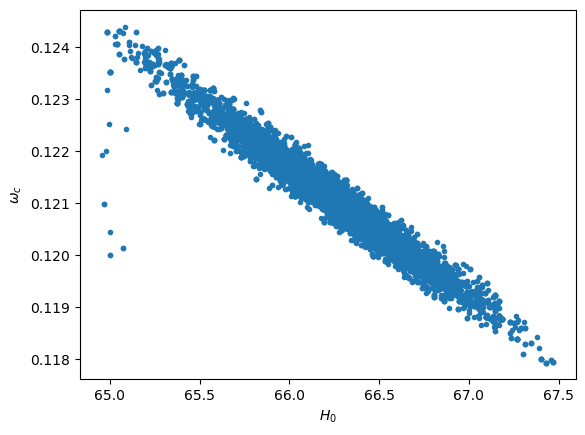

In [26]:
plt.plot(mcmc.chain[:,0], mcmc.chain[:,1], ".")
plt.xlabel(r"$H_0$")
plt.ylabel(r"$\omega_c$")